In [43]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

wandb.init(project="d3pm")
api = wandb.Api()

def split_df(df, x_axis, y_axis, cond=None, median=False, stderr=False):
    if cond is not None:
        df = df[cond]
    y = lambda s: (np.nanmean(np.float64(s[1][y_axis])) if not median else
         np.nanmedian(np.float64(s[1][y_axis])))
    dat = np.array([(s[0], y(s),
                     np.nanstd(np.float64(s[1][y_axis])) / (
                         np.sqrt(len(s[1][y_axis])) if stderr else 1))
                    for s in df.groupby(x_axis)])
    return dat.T

def load_from_dict(key):
    def f(x):
        try:
            if isinstance(key, list):
                for k in key:
                    x = x[k]
                return x
            else:
                return x[key]
        except KeyError:
            return np.nan
    return f

def geq(x, y):
    if x is None:
        return False
    else:
        return x >= y

In [2]:
def load_data(runs, average_n_ep=4):
    data = []
    for run in tqdm(runs):
        history = run.scan_history()
        epoch_data = [row for row in history
                      if (geq(row.get('epoch'), run.config['n_epoch']-average_n_ep)
                          and row.get('val_l01') is not None)]
        if epoch_data:
            average_dict = {key: np.mean([d[key] for d in epoch_data if key in d if isinstance(d[key], float)])
                            for key in set().union(*epoch_data)}
            data.append({
                'config': run.config,
                'summary': run.summary,
                'metrics': average_dict
            })
    return data

<!-- # CIFAR N=4 $\gamma$ sweeps -->

In [3]:
# gamma sweep, uniform
sweep_unif = api.sweep("alanamin/d3pm/9c4b3fe7")
runs_unif = sweep_unif.runs

# gamma sweep, sigma 0.05
sweep_005 = api.sweep("alanamin/d3pm/epdvbiut")
runs_005 = sweep_005.runs

# gamma sweep, sigma 0.1
sweep_01 = api.sweep("alanamin/d3pm/mrgd14rr")
runs_01 = sweep_01.runs

# baselines
# gamma sweep, uniform
sweep_unif_bl = api.sweep("alanamin/d3pm/zxz2tczd")
runs_unif_bl = sweep_unif_bl.runs

# gamma sweep, sigma 0.05
sweep_005_bl = api.sweep("alanamin/d3pm/irgm7thk")
runs_005_bl = sweep_005_bl.runs

# gamma sweep, sigma 0.1
sweep_01_bl = api.sweep("alanamin/d3pm/ky01q6ds")
runs_01_bl = sweep_01_bl.runs

In [71]:
data_unif = load_data(runs_unif, 3)
data_005 = load_data(runs_005, 3)
# data_01 = load_data(runs_01, 3)
data_unif_bl = load_data(runs_unif_bl, 3)
data_005_bl = load_data(runs_005_bl, 3)
# data_01_bl = load_data(runs_01_bl, 3)

df = pd.DataFrame(data_unif, columns=['config', 'summary', 'metrics'])
df_unif = pd.DataFrame({'seed': df['config'].apply(lambda x: x['model.seed']),
                   'gamma': df['config'].apply(lambda x: x['model.gamma']),
                   'nll': df['metrics'].apply(load_from_dict('val_l01')),})

df = pd.DataFrame(data_005, columns=['config', 'summary', 'metrics'])
df_005 = pd.DataFrame({'seed': df['config'].apply(lambda x: x['model.seed']),
                   'gamma': df['config'].apply(lambda x: x['model.gamma']),
                   'nll': df['metrics'].apply(load_from_dict('val_l01')),})

# df = pd.DataFrame(data_01, columns=['config', 'summary', 'metrics'])
# df_01 = pd.DataFrame({'seed': df['config'].apply(lambda x: x['model.seed']),
#                    'gamma': df['config'].apply(lambda x: x['model.gamma']),
#                    'nll': df['metrics'].apply(load_from_dict('val_l01')),})

df_bl = pd.DataFrame(data_unif_bl, columns=['config', 'summary', 'metrics'])
df_unif_bl = pd.DataFrame({'seed': df_bl['config'].apply(lambda x: x['model.seed']),
                      'model': df_bl['config'].apply(lambda x: x['model.model']),
                      'nll': df_bl['metrics'].apply(load_from_dict('val_l01')),})

df_bl = pd.DataFrame(data_005_bl, columns=['config', 'summary', 'metrics'])
df_005_bl = pd.DataFrame({'seed': df_bl['config'].apply(lambda x: x['model.seed']),
                      'model': df_bl['config'].apply(lambda x: x['model.model']),
                      'nll': df_bl['metrics'].apply(load_from_dict('val_l01')),})

# df_bl = pd.DataFrame(data_01_bl, columns=['config', 'summary', 'metrics'])
# df_01_bl = pd.DataFrame({'seed': df_bl['config'].apply(lambda x: x['model.seed']),
#                       'model': df_bl['config'].apply(lambda x: x['model.model']),
#                       'nll': df_bl['metrics'].apply(load_from_dict('val_l01')),})

  0%|                                                    | 0/30 [00:00<?, ?it/s]/vast/aa11803/miniconda3/envs/scud/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/vast/aa11803/miniconda3/envs/scud/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


In [72]:
# temp, while gamma = 0.9 is still running (omg)
# df_005.loc[(df_005['gamma'] == 0.9),'nll'] = (
#     df_005.loc[(df_005['gamma'] == 0.8),'nll'].mean())

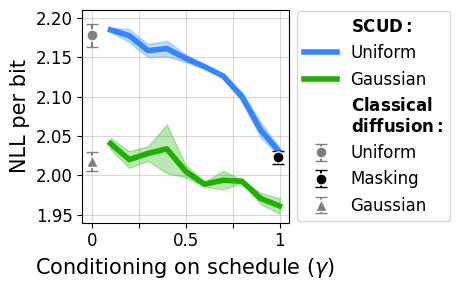

In [103]:
plt.figure(figsize=[4.7, 3])

capsize = 4
markersize = 8
lw = 4
labelsize = 15
ticksize = 12
legendsize = 12
stderr = True

# MD vl1 = 0.0049

def plot_data(x, y, yerr, color, label, marker='o'):
    plt.plot(1-x, y, '-', color=color, zorder=1, lw=lw)
    plt.errorbar(1-x, y, yerr, color=color, fmt='none', capsize=capsize, zorder=2)
    plt.plot(1-x, y, marker, color=color, markeredgecolor='white', markeredgewidth=1, 
             markersize=markersize, zorder=3, label=label)

def plot_data(x, y, yerr, color, label, marker='o'):
    plt.plot(1-x, y, '-', color=color, zorder=1, lw=lw, label=label)
    plt.fill_between(1-x, y-yerr, y+yerr,
                     color=color, zorder=2, alpha=0.3)

plt.plot([1-1], y[x=='SEDD'].astype(float),
             label='$\\mathbf{SCUD:}$', color='white', zorder=3)
plot_data(*split_df(df_unif, 'gamma', 'nll', stderr=stderr), color='#3386FF', label="Uniform")
x, y, yerr = split_df(df_unif_bl, 'model', 'nll', stderr=stderr)
plt.errorbar([1-1], y[x=='SEDD'].astype(float), yerr[x=='SEDD'].astype(float),
             label='Uniform', color='grey', fmt='o', capsize=capsize, markeredgecolor='white', markeredgewidth=1, markersize=markersize, zorder=3)
plt.errorbar([1-1/128], y[x=='MaskingDiffusion'].astype(float), yerr[x=='MaskingDiffusion'].astype(float),
             label='Masking', color='black', fmt='o', capsize=capsize, markeredgecolor='white', markeredgewidth=1, markersize=markersize, zorder=3)

plot_data(*split_df(df_005, 'gamma', 'nll', stderr=stderr), color='#1DB100', label="Gaussian", marker='^')
plt.plot([1-1], y[x=='SEDD'].astype(float),
             label='$\\mathbf{Classical}$\n$\\mathbf{diffusion:}$', color='white', zorder=3)
x, y, yerr = split_df(df_005_bl, 'model', 'nll', stderr=stderr, median=True)
plt.errorbar([1-1], y.astype(float), yerr.astype(float),
             label='Gaussian', color='grey', fmt='^', capsize=capsize, markeredgecolor='white', markeredgewidth=1, markersize=markersize, zorder=3)

# plot_data(*split_df(df_01, 'gamma', 'nll'),color='green', label="Gaussian SCUD")
# x, y, yerr = split_df(df_01_bl, 'model', 'nll')
# plt.errorbar([1-1], y.astype(float), yerr.astype(float),
#              label='Gaussian', color='grey', fmt='^', capsize=capsize, markeredgecolor='white', markeredgewidth=1, markersize=markersize, zorder=3)

plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, "", 0.5, "", 1], fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.ylim(1.94, 2.21)
plt.grid(color='grey', alpha=0.3)
plt.ylabel(f"NLL per bit", fontsize=labelsize)
plt.xlabel("Conditioning on schedule ($\\gamma$)", fontsize=labelsize)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=legendsize)
plt.tight_layout()
plt.savefig("figures/SCUD_result.pdf")